In [1]:
# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, matthews_corrcoef, cohen_kappa_score

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# read the data and show first 5 rows
data = pd.read_csv("/content/bs140513_032310 2.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


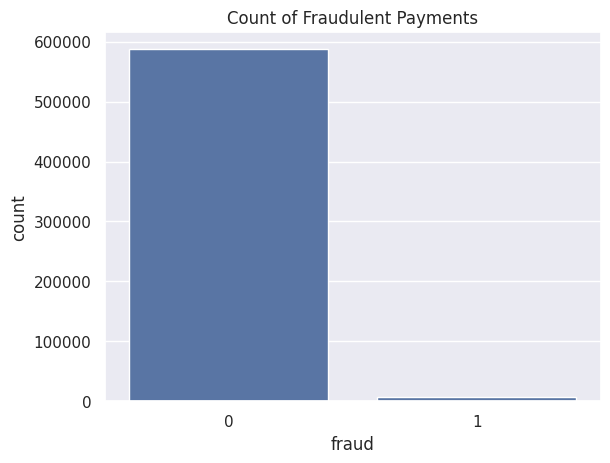

Number of normal examples:  587443
Number of fradulent examples:  7200


In [4]:
# Create two dataframes with fraud and non-fraud data
df_fraud = data.loc[data.fraud == 1]
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

In [5]:
print("Mean feature values per category",data.groupby('category')[['amount','fraud']].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


In [6]:
# Create two dataframes with fraud and non-fraud data
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


/tmp/ipython-input-712181413.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


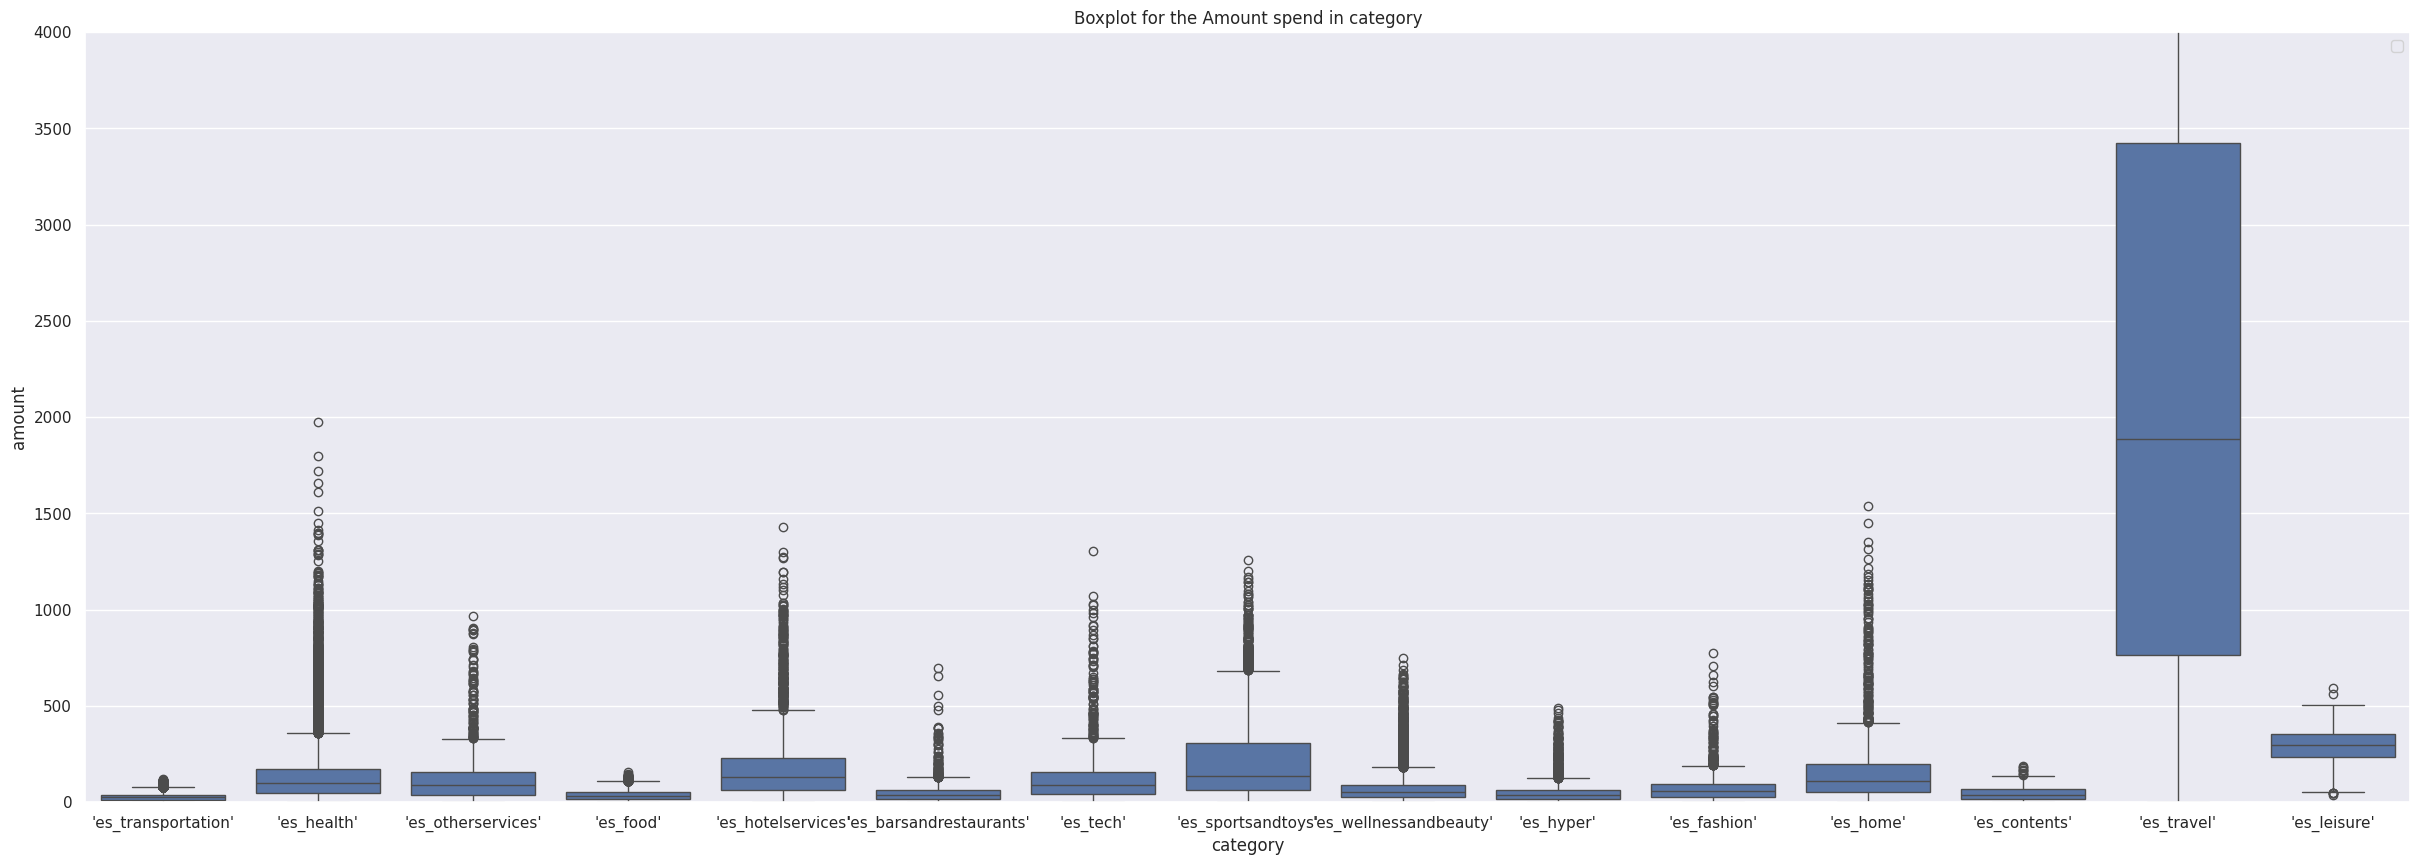

In [7]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

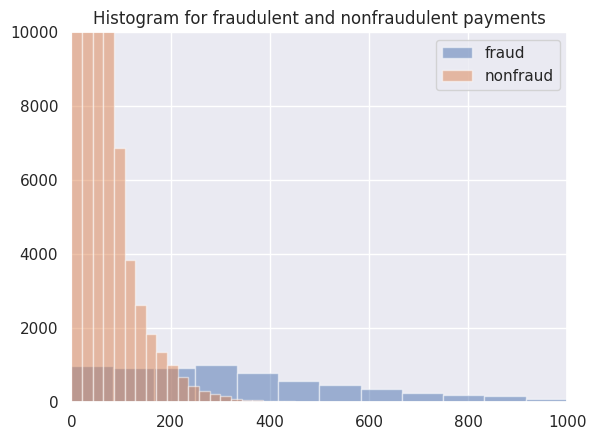

In [8]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [9]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


In [10]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [11]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [12]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [13]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [14]:
y[y==1].count()

np.int64(7200)

In [15]:
# SMOTE (Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res['fraud'].value_counts())

fraud
0    587443
1    587443
Name: count, dtype: int64


In [16]:
# Random Oversampling

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
y_res = pd.DataFrame(y_res, columns=['fraud'])  # Explicitly name the column
print(y_res['fraud'].value_counts())

fraud
0    587443
1    587443
Name: count, dtype: int64


In [17]:
# ADASYN (Adaptive Synthetic Sampling)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)
y_res = pd.DataFrame(y_res, columns=['fraud'])
print(y_res['fraud'].value_counts())

fraud
0    587443
1    586816
Name: count, dtype: int64


In [18]:
# SMOTEENN (SMOTE + Edited Nearest Neighbors)

smoteenn = SMOTEENN(random_state=42)
X_res, y_res = smoteenn.fit_resample(X, y)
y_res = pd.DataFrame(y_res, columns=['fraud'])
print(y_res['fraud'].value_counts())

fraud
1    585301
0    570345
Name: count, dtype: int64


In [19]:
# SMOTETomek (SMOTE + Tomek Links)

smotetomek = SMOTETomek(random_state=42)
X_res, y_res = smotetomek.fit_resample(X, y)
y_res = pd.DataFrame(y_res, columns=['fraud'])
print(y_res['fraud'].value_counts())

fraud
0    587362
1    587362
Name: count, dtype: int64


In [20]:
# Rule-Based Data Generator (Manual Synthetic Data Creation)

# Analyze existing fraud data
df_fraud = data.loc[data.fraud == 1]
fraud_amount_mean = df_fraud['amount'].mean()
fraud_amount_std = df_fraud['amount'].std()
fraud_categories = df_fraud['category'].value_counts().index

# Function to generate synthetic fraud samples
def generate_fraud_samples(n_samples, original_data):
    synthetic_data = pd.DataFrame()
    synthetic_data['customer'] = np.random.choice(original_data['customer'].dropna(), n_samples)
    synthetic_data['age'] = np.random.choice(original_data['age'].dropna(), n_samples)
    synthetic_data['gender'] = np.random.choice(original_data['gender'].dropna(), n_samples)
    synthetic_data['merchant'] = np.random.choice(original_data['merchant'].dropna(), n_samples)
    synthetic_data['category'] = np.random.choice(fraud_categories, n_samples)
    synthetic_data['amount'] = np.random.normal(fraud_amount_mean, fraud_amount_std, n_samples).clip(min=0)
    synthetic_data['fraud'] = 1
    return synthetic_data

# Generate synthetic fraud samples
n_fraud_needed = len(data[data['fraud'] == 0]) - len(df_fraud)  # Match non-fraud count
synthetic_fraud = generate_fraud_samples(n_fraud_needed, data)

# Combine with original data
data_res = pd.concat([data, synthetic_fraud], ignore_index=True)

# Prepare X and y
X_res = data_res.drop(['fraud'], axis=1)
y_res = data_res['fraud']

# Convert categorical columns as in your original code
col_categorical = X_res.select_dtypes(include=['object']).columns
for col in col_categorical:
    X_res[col] = X_res[col].astype('category')
X_res[col_categorical] = X_res[col_categorical].apply(lambda x: x.cat.codes)

print(y_res.value_counts())

fraud
0    587443
1    587443
Name: count, dtype: int64


In [21]:
# I won't do cross validation since we have a lot of instances
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [22]:
# %% Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [23]:
# %% Function for evaluation
def evaluate_model(y_true, y_pred, y_pred_proba):
    """
    Compute and print additional metrics (Specificity, FPR, FNR, Balanced Accuracy, Cohen’s Kappa)
    to complement existing outputs.
    """
    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # MCC
    mcc = matthews_corrcoef(y_true, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # False Positive Rate
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0

    # False Negative Rate
    fnr = fn / (tp + fn) if (tp + fn) > 0 else 0

    # Balanced Accuracy
    balanced_acc = (specificity + (tp / (tp + fn) if (tp + fn) > 0 else 0)) / 2

    # Cohen’s Kappa
    kappa = cohen_kappa_score(y_true, y_pred)

    # Print additional metrics
    print(f"Accuracy: {acc:.6f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")

In [24]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ",
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    176233
           1       0.98      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[172982   3251]
 [  2415 173818]]


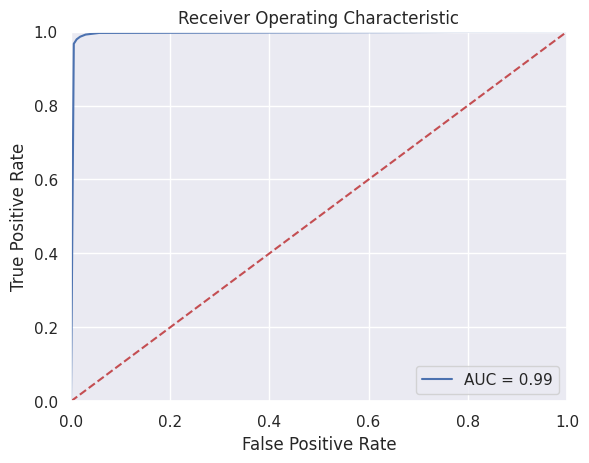

Accuracy: 0.983925
MCC: 0.9679
Specificity: 0.9816
False Positive Rate (FPR): 0.0184
False Negative Rate (FNR): 0.0137
Balanced Accuracy: 0.9839
Cohen’s Kappa: 0.9678


In [25]:
# %% K-ello Neigbors

# Drop the problematic columns from X_train and X_test
# These columns were identified as having only one unique value and caused NaN/ -1 issues
from sklearn.impute import SimpleImputer
X_train_knn = X_train.drop(columns=['zipcodeOri', 'zipMerchant'])
X_test_knn = X_test.drop(columns=['zipcodeOri', 'zipMerchant'])
imputer = SimpleImputer(strategy='mean')
X_train_knn_imputed = imputer.fit_transform(X_train_knn)
X_test_knn_imputed = imputer.transform(X_test_knn)

knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train_knn_imputed,y_train)
y_pred = knn.predict(X_test_knn_imputed)

print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test_knn_imputed)[:,1])
evaluate_model(y_test, y_pred, knn.predict_proba(X_test_knn_imputed)[:, 1])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   28.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   59.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       1.00      1.00      1.00    176233

    accuracy                           1.00    352466
   macro avg       1.00      1.00      1.00    352466
weighted avg       1.00      1.00      1.00    352466

Confusion Matrix of Random Forest Classifier: 
 [[176043    190]
 [   685 175548]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


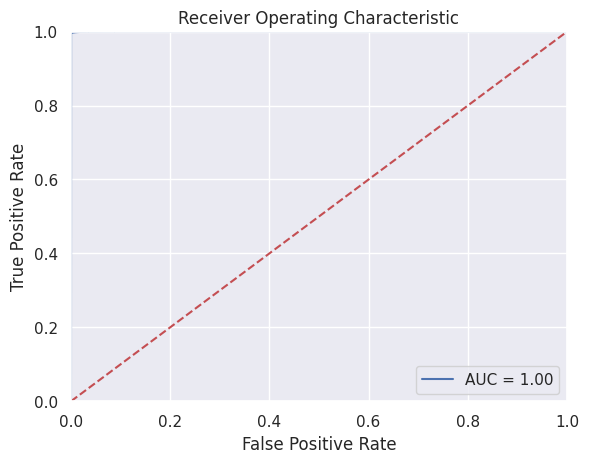

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


Accuracy: 0.997517
MCC: 0.9950
Specificity: 0.9989
False Positive Rate (FPR): 0.0011
False Negative Rate (FNR): 0.0039
Balanced Accuracy: 0.9975
Cohen’s Kappa: 0.9950


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


In [26]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])
evaluate_model(y_test, y_pred, rf_clf.predict_proba(X_test)[:, 1])

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:14:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       1.00      1.00      1.00    176233

    accuracy                           1.00    352466
   macro avg       1.00      1.00      1.00    352466
weighted avg       1.00      1.00      1.00    352466

Confusion Matrix of XGBoost: 
 [[176031    202]
 [   515 175718]]


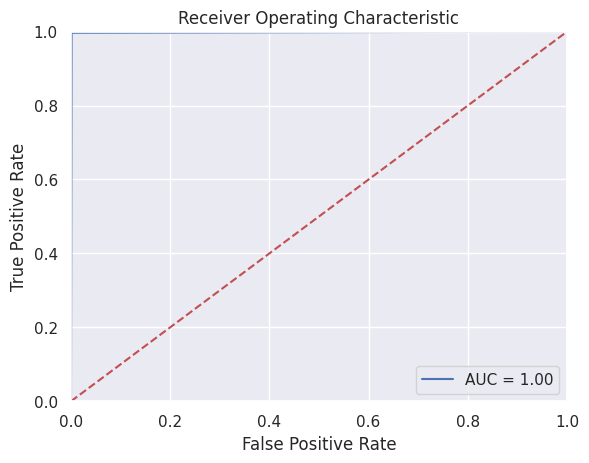

Accuracy: 0.997966
MCC: 0.9959
Specificity: 0.9989
False Positive Rate (FPR): 0.0011
False Negative Rate (FNR): 0.0029
Balanced Accuracy: 0.9980
Cohen’s Kappa: 0.9959


In [27]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400,
                                objective="binary:hinge", booster='gbtree',
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])
evaluate_model(y_test, y_pred, XGBoost_CLF.predict_proba(X_test)[:, 1])

Classification Report for HistGradientBoostingClassifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       1.00      1.00      1.00    176233

    accuracy                           1.00    352466
   macro avg       1.00      1.00      1.00    352466
weighted avg       1.00      1.00      1.00    352466

Confusion Matrix of HistGradientBoostingClassifier: 
 [[176038    195]
 [   504 175729]]


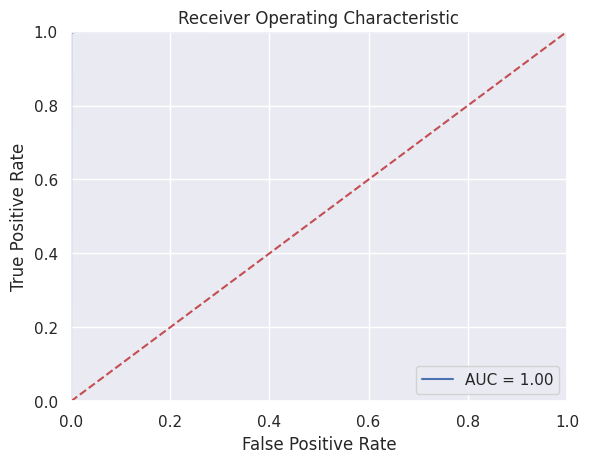

Accuracy: 0.998017
MCC: 0.9960
Specificity: 0.9989
False Positive Rate (FPR): 0.0011
False Negative Rate (FNR): 0.0029
Balanced Accuracy: 0.9980
Cohen’s Kappa: 0.9960


In [28]:
# HGBC - Histogram-Based Gradient Boosting Classifier

# Define the model with class weights
hgbc = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=400,  # Similar to n_estimators
    random_state=42,
    class_weight="balanced"  # Automatically adjusts for imbalance
)

# Fit the model
hgbc.fit(X_train, y_train)
y_pred = hgbc.predict(X_test)

# Evaluate
print("Classification Report for HistGradientBoostingClassifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of HistGradientBoostingClassifier: \n", confusion_matrix(y_test, y_pred))
plot_roc_auc(y_test, hgbc.predict_proba(X_test)[:, 1])
evaluate_model(y_test, y_pred, hgbc.predict_proba(X_test)[:, 1])

Classification Report for LightGBM: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of LightGBM: 
 [[172680   3553]
 [    63 176170]]


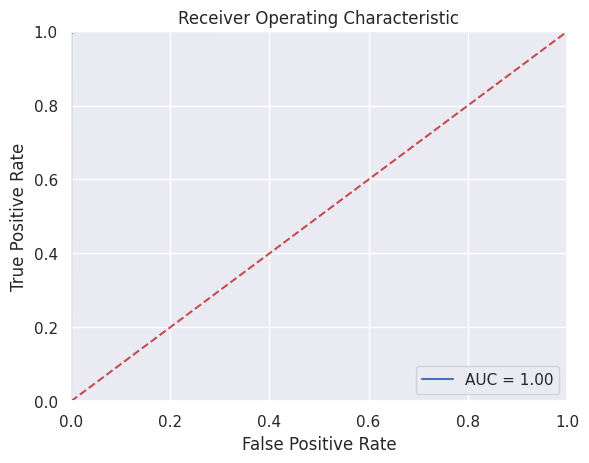

Accuracy: 0.989741
MCC: 0.9797
Specificity: 0.9798
False Positive Rate (FPR): 0.0202
False Negative Rate (FNR): 0.0004
Balanced Accuracy: 0.9897
Cohen’s Kappa: 0.9795


In [29]:
# LightGBM

# Calculate scale_pos_weight (ratio of negative to positive samples)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

# Define the model
lgbm = lgb.LGBMClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=400,
    objective='binary',
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # Adjust for imbalance
    verbosity=-1  # Silent mode
)

# Fit the model
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

# Evaluate
print("Classification Report for LightGBM: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of LightGBM: \n", confusion_matrix(y_test, y_pred))
plot_roc_auc(y_test, lgbm.predict_proba(X_test)[:, 1])
evaluate_model(y_test, y_pred, lgbm.predict_proba(X_test)[:, 1])

Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    176233
           1       0.19      0.87      0.31      2160

    accuracy                           0.95    178393
   macro avg       0.59      0.91      0.64    178393
weighted avg       0.99      0.95      0.97    178393

Confusion Matrix of Logistic Regression: 
 [[168093   8140]
 [   284   1876]]


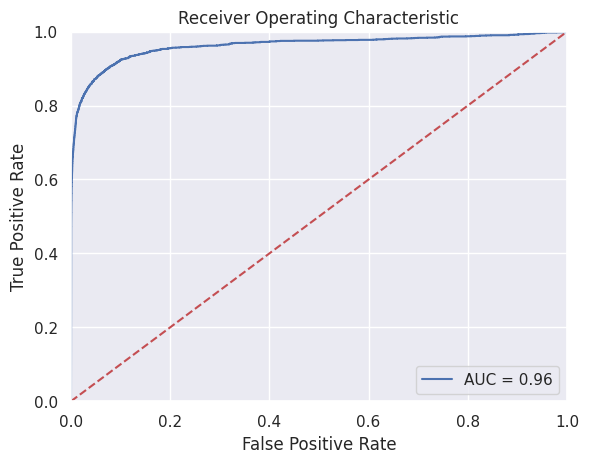

Accuracy: 0.952778
MCC: 0.3907
Specificity: 0.9538
False Positive Rate (FPR): 0.0462
False Negative Rate (FNR): 0.1315
Balanced Accuracy: 0.9112
Cohen’s Kappa: 0.2941


In [31]:
# Logistic Regression

X_n = data_reduced.drop(['fraud'], axis=1)
y_n = data_reduced['fraud']

# Split data
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_n)
X_test_scaled = scaler.transform(X_test_n)

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train_n)
y_pred = lr.predict(X_test_scaled)
y_pred_proba = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Classification Report for Logistic Regression: \n", classification_report(y_test_n, y_pred))
print("Confusion Matrix of Logistic Regression: \n", confusion_matrix(y_test_n, y_pred))
plot_roc_auc(y_test_n, y_pred_proba)
evaluate_model(y_test_n, y_pred, y_pred_proba)